In [19]:
### Import libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **Import Training and Testing set**

*We will use SMOTE balanced dataset for the purpose of tunning the hyperparameters* 

In [22]:
train_smote = pd.read_pickle("data/train_smote.pickle")
test = pd.read_pickle("data/test.pickle")

### **Split Attributes and Target Class**

In [23]:
x = train_smote.iloc[:, :-1]
y = train_smote["Class"]

### **Split training and validation set**

In [24]:
from sklearn.model_selection import train_test_split
xtrain, xvalid, ytrain, yvalid = train_test_split(x, y, test_size=0.25, stratify=y,random_state=123)

### **Random Forest**

*We will use Random Forest Classifier to train our model. Random Forest is an ensemble technique which uses a number of weak
classifiers and implement a majority vote to classify the sample into target class*

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 300)
    min_samples_split = trial.suggest_int("min_samples_split", 10, 100)
    max_features = trial.suggest_float("max_features", 0.5, 1.0)
    n_jobs = -1
    rfc = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split,
                                 max_features=max_features, n_jobs=n_jobs)
    rfc.fit(xtrain, ytrain)
    ypred = rfc.predict(xvalid)
    auc = roc_auc_score(yvalid, ypred)
    return auc

### **Tunning Hyperparameter**

*Following hyperparameters are needed to be tuned using optuna.*
1. n_estimators
2. min_sample_split
3. max_features

In [28]:
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=20 )

[I 2022-07-22 17:58:11,661] A new study created in memory with name: no-name-bd674482-f583-4392-9b18-e8a4c978435f


KeyboardInterrupt: 

### **Fitting model**

*We implement function that fits the data with specific hyperparameters to the Random Forest model and then 
prints the precision recall for target classes in test set with the confusion matrix of validation and 
test set*

In [29]:
### RFC function 

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

def rfc_fit(train_set, ):
    xtrain, xvalid, ytrain, yvalid = train_test_split(train_set.iloc[:,:-1], train_set["Class"], test_size=0.25, random_state=123)
    rfc = RandomForestClassifier(n_estimators=250, min_samples_split=10, max_features=0.65, n_jobs=-1)
    rfc.fit(xtrain, ytrain)
    v_pred = rfc.predict(xvalid)
    y_pred = rfc.predict(test.iloc[:,:-1])
    vcm = confusion_matrix(yvalid,v_pred)
    ycm = confusion_matrix(test["Class"], y_pred)
    fig , axes = plt.subplots(1,2)
    fig1 = sns.heatmap(vcm, cmap="Greens", linewidths=0.9, cbar=False, annot=True, fmt ="d",ax=axes[0])
    fig2 = sns.heatmap(ycm, cmap="Greens", linewidths=0.9, cbar=False, annot=True, fmt ="d",ax=axes[1])
    fig1.set(xlabel="Predicted", ylabel="Truth")
    fig1.set_title("Validation")
    fig2.set(xlabel="Predicted", ylabel="Truth")
    fig2.set_title("Test")
    fig.suptitle("Random Forest")
    plt.tight_layout()
    print(classification_report(test["Class"], y_pred))

In [34]:
### predictions on different synthetically balanced datasets

### **Undersampling**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.42      0.83      0.56       123

    accuracy                           1.00     71202
   macro avg       0.71      0.91      0.78     71202
weighted avg       1.00      1.00      1.00     71202



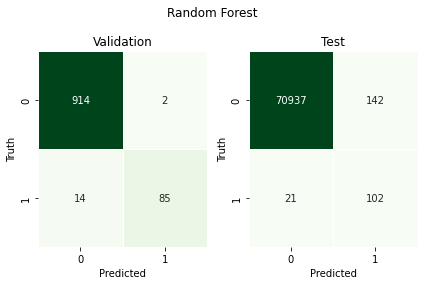

In [35]:
train_under = pd.read_pickle("data/train_under.pickle")
rfc_fit(train_under)

### **Bootstrap Sampling**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.94      0.74      0.83       123

    accuracy                           1.00     71202
   macro avg       0.97      0.87      0.91     71202
weighted avg       1.00      1.00      1.00     71202



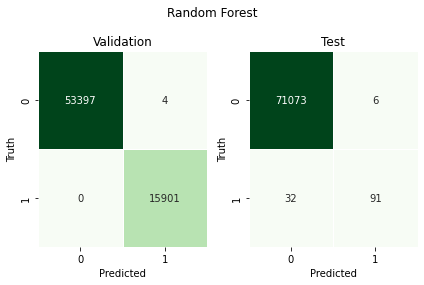

In [36]:
train_over = pd.read_pickle("data/train_over.pickle")
rfc_fit(train_over)

### **Oversampling with shrinkage**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.57      0.84      0.68       123

    accuracy                           1.00     71202
   macro avg       0.78      0.92      0.84     71202
weighted avg       1.00      1.00      1.00     71202



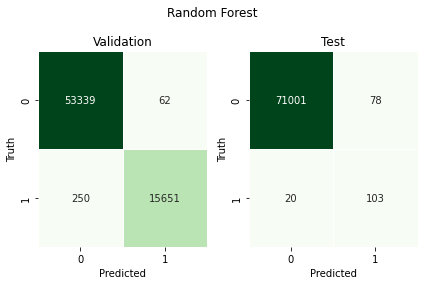

In [37]:
train_over_shrink = pd.read_pickle("data/train_over_shrink.pickle")
rfc_fit(train_over_shrink)

### **SMOTE**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.84      0.78      0.81       123

    accuracy                           1.00     71202
   macro avg       0.92      0.89      0.90     71202
weighted avg       1.00      1.00      1.00     71202



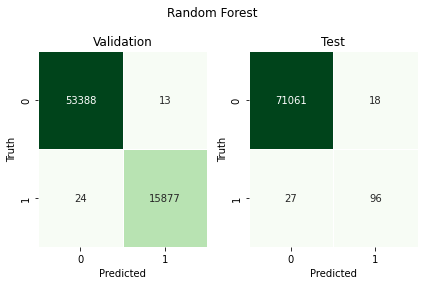

In [38]:
rfc_fit(train_smote)

### **ADASYN**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.83      0.78      0.80       123

    accuracy                           1.00     71202
   macro avg       0.91      0.89      0.90     71202
weighted avg       1.00      1.00      1.00     71202



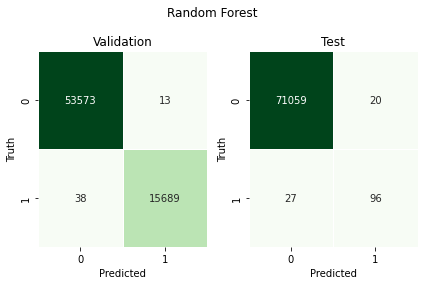

In [39]:
train_adasyn = pd.read_pickle("data/train_adasyn.pickle")
rfc_fit(train_adasyn)

### **Save Model**

In [ ]:
xtrain = train_over_shrink.iloc[:, :-1].to_numpy()
ytrain = train_over_shrink["Class"].to_numpy()
rfc = RandomForestClassifier(n_estimators=250, min_samples_split=10, max_features=0.65, n_jobs=-1)
rfc.fit(xtrain, ytrain)

In [69]:
import joblib
joblib.dump(rfc, "models/rfc.pkl")

['models/lgb.pkl']